# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


Setup (frame only; deterministic)
- Procedure: Build n = 1000 (200 wedding, 800 brunch) via list multiplication + pandas.DataFrame(...)
- Frame: all attendees
- Size: 1000
- Distribution: None

Infection Assignment (Simple Random Sampling without Replacement)
- Procedure: Fixed-size random subset of attendees is marked infected
- Functions: numpy.random.choice(ppl.index, size=int(len(ppl)*ATTACK_RATE), replace=False); then ppl.loc[indices,'infected']=True
- Frame: All 1,000 attendees
- Size: Fixed n = 100 (10% of 1000)
- Distribution: Event-specific infected counts are hypergeometric, marginal inclusion Bernoulli (0.10) but jointly constrained by fixed n. 

Primary contact tracing (Bernoulli (a.k.a Poisson) Sampling)
- Procedure: Each infected is independently included (traced) with probability p = 0.20, sample size is random. 
- Functions: numpy.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS; assigned via .loc[...]
- Frame: infected only (from Stage 1, k = 100)
- Size: random, E[n] = k x 0.20
- Distribution: Per person Bernoulli (0.20), total traced Binomial (k, 0.20); by event, Binomial with event-specific n. 

Secondary (cascade) tracing (Adaptive Cluster Sampling, threshold-triggered akin to snowball)
- Procedure: If an event has >/=2 primary traced cases. all infected in that event are included (traced). Inclusion is outcome-dependent and unequal
- Functions: value_counts() on ppl[ppl['traced']==True]['event']; pick events meeting SECONDARY_TRACE_THRESHOLD=2; set via boolean indexing ppl.loc[...] = True.
- Frame: infected, grouped by event (wedding, brunch)
- Size: deterministic conditional on activation (all infected in activated clusters)
- Distribution: No new RNG, randomness inherited from other 2 stages. This induces selection bias toward cluster that cross the threshold. 

Repeated Runs (Monte Carlo resampling of the stochastic process, not bootstrap)
- Procedure: Independently repeat previous 3 stages to sample from the process's outcome distribution
- Function: [simulate_event(m) for m in range(1000)]; aggregate with pandas.DataFrame(...).
- Frame: Space of possible realizations under model parameters
- Size: R = 1000 runs 
- Distributions: Empirical sampling distributions of “Infections” (wedding share of infections) and “Traces” (wedding share among traced), driven by Hypergeometric + Binomial and magnified by adaptive clustering. 



Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

R = 10
- Big run-to-run jitter; only 10 points per histogram --> sparse, jumpy bars.
- “Traces” is especially volatile: crossing the >/= 2 threshold can flip an entire event to “all traced.”
- Mean of “Infections” still near ~0.20 (200/1000), but shapes differ a lot between runs.
- Poor reproducibility, histograms are sparse/jagged, "Traces" can jump a lot from each run.

R = 100
- Much smoother histograms; “Infections” clearly centered near  approximately 0.20.
- “Traces” remains upward-biased, but with a steadier shape.
- Less sensitive to any single lucky/unlucky event.
- Moderate reproduciility, "Infections" centers near approximately 0.20; "traces" steadier, but still variable. 

R = 1000
- High reproducibility, both summaries stability visibly.



Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The output needs to produce the same output when run multiple times.

1. Fixed the random-number generator
    - Change: Replaced implicit global RNG calls (np.random.choice, np.random.rand) with a seeded, explicit generator: rng = np.random.default_rng(42) and then rng.choice(...), rng.random(...).
    - Effect: With the same RNG_SEED and same number of repetitions R, the simulation produces identical results and identical plots every time you run the script.
2. Thread-safe, modern API
    - Change: Use of NumPy’s Generator/PCG64 (default_rng) instead of the legacy global state.
    - Effect: More stable and predictable sequences; avoids accidental differences if other code elsewhere touches np.random’s global state.
3. Explicit RNG passed into the simulation
    - Change: simulate_event takes rng as an argument and uses only that source of randomness.
    - Effect: Prevents hidden or split RNG state; ensures each run advances the same deterministic sequence.

With these changes, running the script multiple times yields the same outputs (both the numeric results in props_df and the histogram shapes), as long as RNG_SEED and R are unchanged. If you change the seed or R, you’ll get a different—but still fully reproducible—result for that new configuration.

## Code

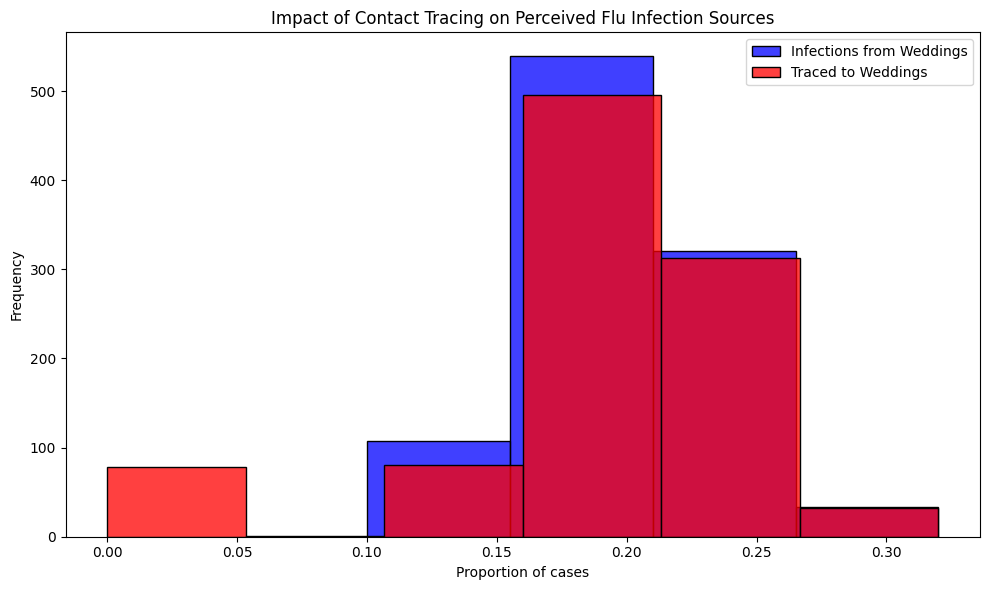

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RNG_SEED = 42
rng = np.random.default_rng (RNG_SEED)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m, rng):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': pd.NA # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m, rng) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 12/10/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
